# Эксперименты с временным рядом стоимости меди с моделью Catboost

In [1]:
import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 60)
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from darts import TimeSeries
from darts.metrics import mape
from darts.models import CatBoostModel
from darts.dataprocessing.transformers import Scaler

from datetime import timedelta
from copy import deepcopy
import random
#import torch
import optuna
from functools import partial

In [2]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    
set_seed()

## Data

In [3]:
FORECAST_LEN = 4 # Длина прогноза
OUT_OF_TIME_DIM = 20 # Размер отложенной выборки

In [4]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    
set_seed()

In [18]:
df = pd.read_csv('prepared_dataset_al.csv', parse_dates=[0], dtype='float32')
print('Shape:', df.shape)

Shape: (282, 67)


In [19]:
df

,date,bloomberg_metals_price_mean_4,chalco_adj_std_13,usa_inflation_value_shift_13,usd_to_hkd_increment_by_mean_26,rual_price_std_26,ftse_index_std_13,hongqiao_adj_std_4,alcoa_price_std_4,norsk_hydro_adj_std_4,bloomberg_metals_price_std_9,chalco_price_std_4,eu_inflation_value_increment_by_mean_26,ftse_index_std_4,USD_JPY_rate_increment_by_mean_26,ftse_index_change_mean_52,eu_inflation_value_std_13,rual_price_std_13,baltic_dry_index_std_9,export_australia_value_std_26,australia_pmi_std_26,sp_metals_price_std_4,bloomberg_metals_price_std_4,USD_EUR_rate_std_26,import_usa_value_std_13,export_usa_value_std_9,guinea_inflation_std_26,sp_metals_price_std_9,usa_gdp_increment_value,norsk_hydro_adj_increment_by_mean_26,...,log10_kaiser_volume_std_9,brazil_inflation_std_26,log10_kaiser_volume_std_4,mosexchange_value_std_4,shanghai_index_std_4,import_brazil_value_std_26,import_usa_value_increment_by_mean_26,ftse_index_change_std_13,guinea_inflation_std_13,export_usa_value_std_26,export_usa_value_increment_by_mean_26,USD_EUR_rate_std_13,ftse_index_change_mean_26,export_brazil_value_std_13,sp_metals_change_std_9,rual_price_change_mean_26,export_brazil_value_increment_by_mean_26,rual_price_change_std_26,rual_price_change_std_13,china_pmi2_value_std_13,log10_alcoa_volume_std_13,log10_alcoa_volume_std_9,export_china_value_increment_by_mean_26,covid,after_feb,lme_price_smooth,target_1,target_2,target_3,target_4
0,2018-06-03,136.120178,0.225700,0.2,0.000788,5.279096,499.688293,0.064213,2.505895,1.031003,2.600087,0.135393,0.021429,151.190262,1.428163,0.883725,0.043584,4.827188,174.694855,25.504187,0.755143,20.883348,0.689518,0.018089,151538.562500,557133.250000,0.047933,57.444756,3.3,2.256488,...,0.147016,0.088398,0.163565,37.855099,28.121435,14.534184,172160.984375,6.953123,0.046517,519646.906250,750872.625000,0.018548,0.883725,19.712618,0.629137,-0.585663,-16.288807,3.338836,3.474779,0.829700,0.167162,0.190899,-47581.386719,0.000000,0.000000,2274.880127,NaN,NaN,NaN,NaN
1,2018-06-10,137.564819,0.227441,0.4,0.001307,5.127011,506.845306,0.061951,1.248856,1.118092,2.390589,0.108999,-0.300000,156.271317,1.836952,0.814810,0.101789,4.334586,153.274048,25.036188,0.730966,21.895279,2.602970,0.018642,154912.671875,540342.312500,0.048735,51.247894,3.3,3.465743,...,0.148763,0.085895,0.177403,77.180725,27.513264,14.256364,110622.789062,6.957414,0.046517,537920.250000,710315.250000,0.019084,0.814810,21.897911,0.614062,-0.547714,37.484314,3.220738,3.459088,0.809838,0.170098,0.197767,119669.101562,0.000000,0.000000,2307.406494,32.526360,NaN,NaN,NaN
2,2018-06-17,138.300537,0.246888,0.4,0.002545,5.055682,505.386993,0.067456,0.595548,1.235748,2.394314,0.087519,-0.281250,99.151421,2.346250,0.755134,0.132924,3.869229,126.820877,24.569300,0.708951,22.850105,2.406668,0.019502,157772.593750,488282.406250,0.049134,47.874294,3.3,3.458110,...,0.136413,0.083580,0.168514,57.172558,22.521772,13.981581,103708.867188,6.954554,0.046517,549182.937500,665920.562500,0.019707,0.755134,23.804491,0.599011,-0.614420,35.141544,3.122948,3.467330,0.773398,0.168818,0.191154,112189.789062,0.000000,0.000000,2283.989746,-23.416666,9.109694,NaN,NaN
3,2018-06-24,137.646881,0.318309,0.4,0.001900,5.076571,533.758240,0.237979,1.730484,0.883078,2.447601,0.211213,-0.264706,142.608673,1.861345,0.672059,0.154346,3.483871,120.236656,24.110804,0.688797,26.696520,3.442994,0.020365,160145.875000,386971.343750,0.049259,47.496651,3.3,1.764906,...,0.134377,0.081433,0.114357,89.822289,24.967325,13.713371,97608.343750,6.911727,0.046517,555731.125000,626748.750000,0.019909,0.672059,25.494965,0.598339,-0.644664,33.074394,3.026352,3.466061,0.717861,0.171967,0.113050,105590.382812,0.000000,0.000000,2200.806152,-83.183670,-106.600342,-74.073982,NaN
4,2018-07-01,135.948212,0.398990,0.4,0.002152,5.084261,569.287537,0.332562,1.878480,1.657978,3.173083,0.347230,-0.250000,213.679337,2.049365,0.610436,0.169772,2.731725,120.403732,23.664864,0.670259,52.683071,5.073675,0.020888,162053.906250,161093.781250,0.049197,45.7726

In [20]:
df.dtypes

date                               datetime64[ns]
bloomberg_metals_price_mean_4             float32
chalco_adj_std_13                         float32
usa_inflation_value_shift_13              float32
usd_to_hkd_increment_by_mean_26           float32
                                        ...      
lme_price_smooth                          float32
target_1                                  float32
target_2                                  float32
target_3                                  float32
target_4                                  float32
Length: 67, dtype: object

In [6]:
df.describe()

,bloomberg_metals_price_mean_4,chalco_adj_std_13,usa_inflation_value_shift_13,usd_to_hkd_increment_by_mean_26,rual_price_std_26,ftse_index_std_13,hongqiao_adj_std_4,alcoa_price_std_4,norsk_hydro_adj_std_4,bloomberg_metals_price_std_9,chalco_price_std_4,eu_inflation_value_increment_by_mean_26,ftse_index_std_4,USD_JPY_rate_increment_by_mean_26,ftse_index_change_mean_52,eu_inflation_value_std_13,rual_price_std_13,baltic_dry_index_std_9,export_australia_value_std_26,australia_pmi_std_26,sp_metals_price_std_4,bloomberg_metals_price_std_4,USD_EUR_rate_std_26,import_usa_value_std_13,export_usa_value_std_9,guinea_inflation_std_26,sp_metals_price_std_9,usa_gdp_increment_value,norsk_hydro_adj_increment_by_mean_26,rual_price_std_4,...,log10_kaiser_volume_std_9,brazil_inflation_std_26,log10_kaiser_volume_std_4,mosexchange_value_std_4,shanghai_index_std_4,import_brazil_value_std_26,import_usa_value_increment_by_mean_26,ftse_index_change_std_13,guinea_inflation_std_13,export_usa_value_std_26,export_usa_value_increment_by_mean_26,USD_EUR_rate_std_13,ftse_index_change_mean_26,export_brazil_value_std_13,sp_metals_change_std_9,rual_price_change_mean_26,export_brazil_value_increment_by_mean_26,rual_price_change_std_26,rual_price_change_std_13,china_pmi2_value_std_13,log10_alcoa_volume_std_13,log10_alcoa_volume_std_9,export_china_value_increment_by_mean_26,covid,after_feb,lme_price_smooth,target_1,target_2,target_3,target_4
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,...,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,2.820000e+02,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,2.820000e+02,282.000000,282.000000,282.000000,281.000000,280.000000,279.000000,278.000000
mean,138.559113,0.319516,0.309423,-0.000843,4.249986,273.543396,0.259927,1.800147,1.449233,4.563441,0.168945,0.227759,139.332413,1.663174,0.111457,0.181089,2.888936,264.172943,38.807678,1.468726,61.469463,2.826630,0.015950,130076.195312,143881.859375,0.477580,95.824181,2.179436,1.091418,1.485700,...,0.181229,0.768479,0.155476,171.235138,54.980236,18.217363,17068.943359,1.026909,0.329527,260680.625000,3.658002e+04,0.010979,0.086928,11.451565,0.859504,0.069141,1.836829,1.367122,1.222799,1.929837,0.131023,0.120998,4.268951e+04,0.228467,0.162726,2187.586670,-0.311324,-0.602007,-0.583585,-0.399618
std,27.089277,0.184627,0.315599,0.019017,2.630195,177.179459,0.196332,1.611941,1.076748,3.385589,0.137156,0.419358,106.679466,4.338950,0.205780,0.113887,2.095899,173.432083,11.945754,0.910203,42.420738,2.543974,0.008652,86156.429688,199285.578125,0.447644,59.999840,3.307303,5.963383,1.465832,...,0.074597,0.416949,0.079136,149.405640,60.812988,7.940274,280205.500000,0.880100,0.404302,222130.921875,3.697457e+05,0.006033,0.254548,7.060465,0.334876,0.259328,17.119184,0.726316,0.823724,2.333842,0.064236,0.058733,3.875421e+05,0.388796,0.300243,440.553650,54.538860,88.763176,113.060982,135.670944
min,92.510361,0.052547,-0.800000,-0.061387,0.997777,54.833698,0.012340,0.180923,0.099812,0.709486,0.013164,-0.456593,17.186796,-9.918187,-0.298297,0.000000,0.633519,32.954060,20.460823,0.315536,1.132393,0.132410,0.004820,13935.265625,4.350456,0.047933,25.982565,-7.500000,-17.344406,0.151132,...,0.062280,0.075746,0.025223,11.993413,3.007912,5.112617,-739684.187500,0.358280,0.000000,34.463089,-1.048385e+06,0.003077,-0.383544,1.025469,0.357106,-0.644664,-45.708199,0.519534,0.443797,0.123188,0.063388,0.044006,-2.087662e+06,0.000000,0.000000,1479.717651,-250.823135,-405.278900,-482.037415,-501.510193
25%,115.814018,0.181782,0.114286,-0.007432,2.388422,157.340839,0.104818,0.797250,0.685221,2.282125

In [24]:
df.columns.values[1:-5]

array(['bloomberg_metals_price_mean_4', 'chalco_adj_std_13',
       'usa_inflation_value_shift_13', 'usd_to_hkd_increment_by_mean_26',
       'rual_price_std_26', 'ftse_index_std_13', 'hongqiao_adj_std_4',
       'alcoa_price_std_4', 'norsk_hydro_adj_std_4',
       'bloomberg_metals_price_std_9', 'chalco_price_std_4',
       'eu_inflation_value_increment_by_mean_26', 'ftse_index_std_4',
       'USD_JPY_rate_increment_by_mean_26', 'ftse_index_change_mean_52',
       'eu_inflation_value_std_13', 'rual_price_std_13',
       'baltic_dry_index_std_9', 'export_australia_value_std_26',
       'australia_pmi_std_26', 'sp_metals_price_std_4',
       'bloomberg_metals_price_std_4', 'USD_EUR_rate_std_26',
       'import_usa_value_std_13', 'export_usa_value_std_9',
       'guinea_inflation_std_26', 'sp_metals_price_std_9',
       'usa_gdp_increment_value', 'norsk_hydro_adj_increment_by_mean_26',
       'rual_price_std_4', 'australia_inflation_increment_by_mean_26',
       'australia_inflation_std_

In [7]:
FORECAST_LEN = 4 # Длина прогноза
OUT_OF_TIME_DIM = 20 # Размер отложенной выборки

# Извлекаем временной ряд с ценами на alum
data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
# Извлекаем коварианты
data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=df.columns.values[1:-5])
# Возьмем срез данных для всего процесса развития модели ts & past_cov и out-of-time выборку
ts = data_ts[:-OUT_OF_TIME_DIM]
past_cov = data_past_cov[:-OUT_OF_TIME_DIM]
# Размер выборки out-of-time = 20 точек (то есть 20 недель)
# out-of-time выборка будет использована лишь в самом конце

<Axes: xlabel='date'>

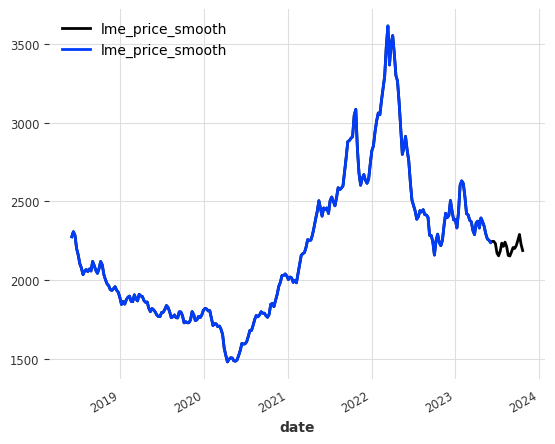

In [47]:
data_ts.plot()
ts.plot()

In [8]:
import datetime

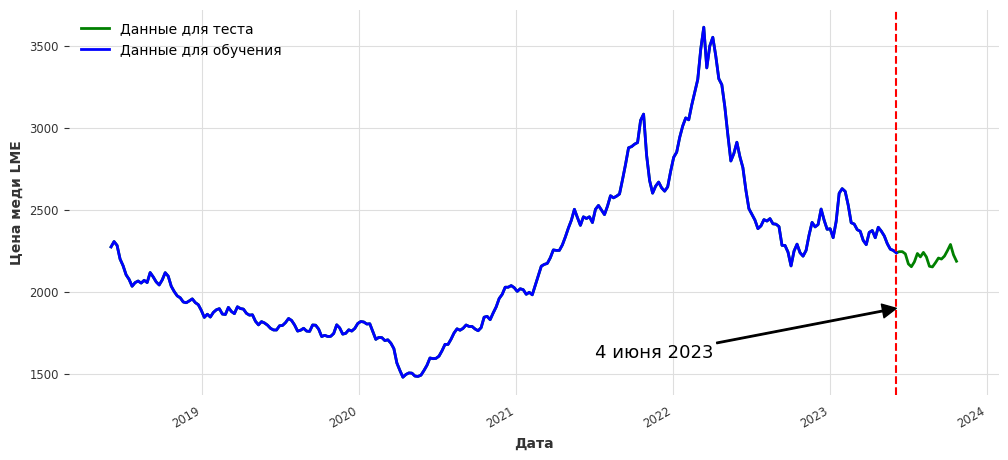

In [9]:
# Рисуем
# Рисуем
fig, ax = plt.subplots(figsize=(12, 5))
data_ts.plot(label="Данные для теста", color='g')
ts.plot(label="Данные для обучения", color='b')
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.annotate('4 июня 2023', xy=(ts.end_time(), 1900), xytext=(ts.end_time() - datetime.timedelta(700), 1600),
            arrowprops=dict(facecolor='black', width=1, headwidth=10, headlength=10), fontsize = 13
            )
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
plt.savefig('pic1.png', dpi=400, format='png')

<Axes: xlabel='date'>

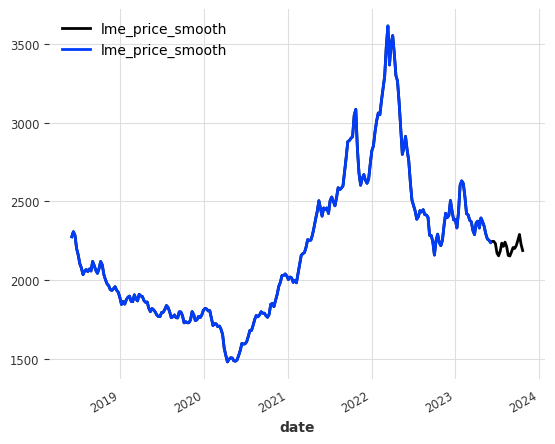

In [16]:
data_ts.plot()
ts.plot()

In [10]:
#Рандомное обучение с параметрами наугад

In [11]:
cbr = CatBoostModel(lags=26,
                    lags_past_covariates=13,
                    depth=4,
                    output_chunk_length=FORECAST_LEN,
                    eval_metric = "MAPE",
                    task_type = "CPU",
                    thread_count = 16,
                    random_state=42)

shift = max(cbr.model_params["lags"], cbr.model_params["lags_past_covariates"])
ts_train, ts_valid = ts[ : - int(FORECAST_LEN)], ts[- int(FORECAST_LEN) - shift : ]
past_cov_train, past_cov_valid = past_cov[ : - int(FORECAST_LEN)], past_cov[- int(FORECAST_LEN) - shift : ]
cbr.fit(series=ts_train,
        past_covariates=past_cov_train,
        val_series=ts_valid,
        val_past_covariates=past_cov_valid, verbose=False
       )

CatBoostModel(lags=26, lags_past_covariates=13, lags_future_covariates=None, output_chunk_length=4, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, depth=4, eval_metric=MAPE, task_type=CPU, thread_count=16)

In [12]:
# Тест без переобучения

In [13]:
start_point = 0
out_of_time_metrics_no_refit = list()
prediction_curves = {}
step = 1
shift = max(cbr.model_params["lags"], cbr.model_params["lags_past_covariates"])
out_of_time_ts = data_ts[-(OUT_OF_TIME_DIM + shift):]
out_of_time_past_cov = data_past_cov[-(OUT_OF_TIME_DIM + shift):]
while True:
    cur_test_input = out_of_time_ts[start_point : start_point + shift]
    past_cov_test_input = out_of_time_past_cov[start_point : start_point + shift]
    prediction = cbr.predict(int(FORECAST_LEN), series=cur_test_input, past_covariates=past_cov_test_input)
    metric = mape(prediction, out_of_time_ts)
    out_of_time_metrics_no_refit.append(metric)
    start_point+=step
    prediction_curves[start_point]=prediction
    if start_point + shift + int(FORECAST_LEN) > len(out_of_time_ts):
        break

print("MAPE: {:.2f} +- {:.2f}".format(np.mean(out_of_time_metrics_no_refit), np.std(out_of_time_metrics_no_refit)))

MAPE: 2.41 +- 1.10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

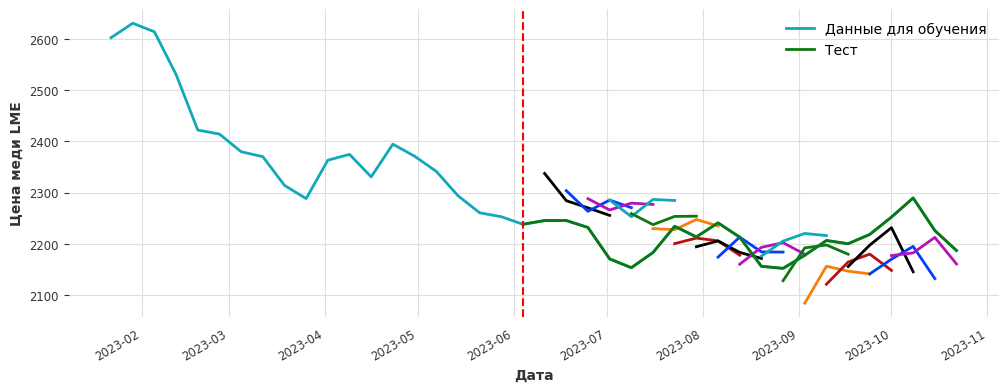

In [50]:
fig, ax = plt.subplots(figsize=(12, 4))
for key, value in prediction_curves.items():
    value.plot(label=None)
data_ts[-2*OUT_OF_TIME_DIM:].plot(label='Данные для обучения')
data_ts[-OUT_OF_TIME_DIM-1:].plot(label='Тест')
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
plt.savefig('pic3.png', dpi=400, format='png')

Text(0.5, 0, 'Number of prediction on the out-of-time set')

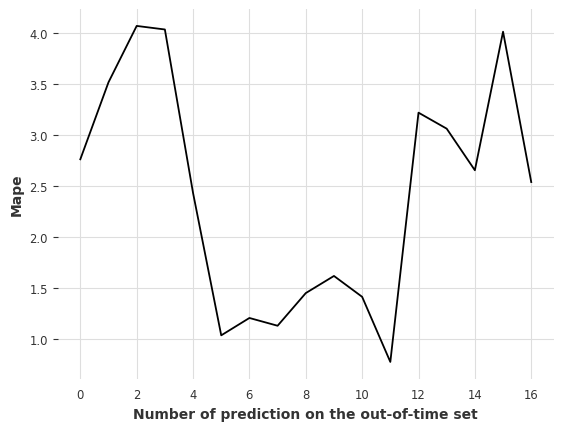

In [30]:
fig, ax = plt.subplots()
ax = sns.lineplot(out_of_time_metrics_no_refit)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of prediction on the out-of-time set')

In [ ]:
# Бэктест

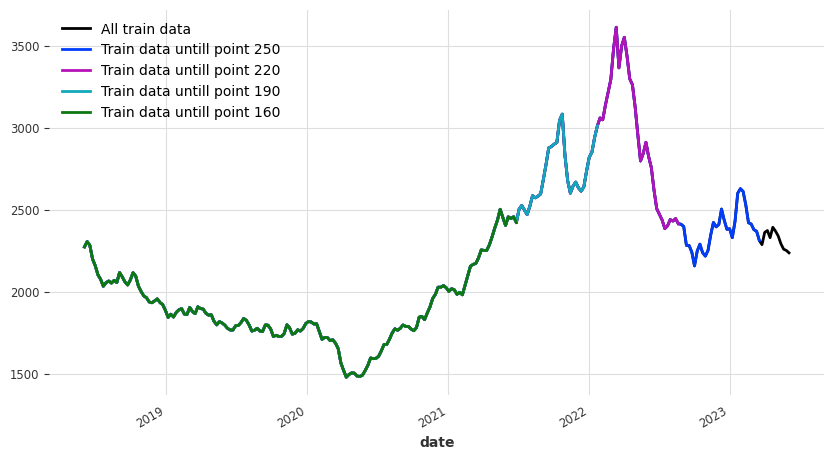

In [38]:
plt.figure(figsize=(10,5))
ts.plot(label='All train data')
for i in range(250, 149, -30):
    ts[:i+1].plot(label='Train data untill point '+str(i))

In [39]:
# Извлекаем временной ряд с ценами на медь
data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
# Извлекаем коварианты
data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=df.columns.values[1:-5])
# Возьмем срез данных для всего процесса развития модели ts & past_cov и out-of-time выборку
ts = data_ts[:-OUT_OF_TIME_DIM]
past_cov = data_past_cov[:-OUT_OF_TIME_DIM]
# Размер выборки out-of-time = 26 точек (то есть 26 недель = 6 месяцев)
# out-of-time выборка будет использована лишь в самом конце

In [41]:
cbr_backtest = CatBoostModel(lags=26,
                    lags_past_covariates=13,
                    depth=4,
                    output_chunk_length=FORECAST_LEN,
                    eval_metric = "MAPE",
                    task_type = "CPU",
                    thread_count = 16,
                    random_state=42)

bt_metrics, pred_ts = manual_backtest(model=cbr_backtest,
                                      ts=ts,
                                      past_covariates=past_cov,
                                      forecast_horizont=FORECAST_LEN,
                                      start_test=160, step = 30, save_curves=True,
                                      rolling_window=False, window_size=None)

print("MAPE: {:.2f} +- {:.2f}".format(np.mean(bt_metrics), np.std(bt_metrics)))

MAPE: 9.04 +- 5.20


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


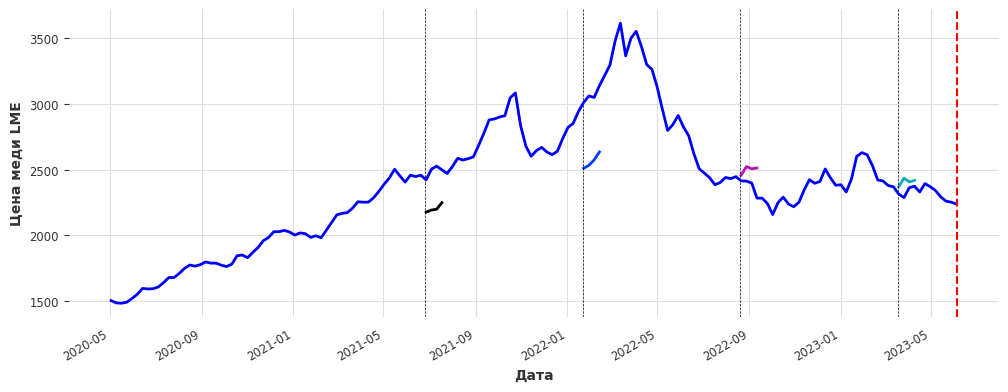

In [51]:
fig, ax = plt.subplots(figsize=(12, 4))
for key, value in pred_ts.items():
    value.plot(label=None);
    ax.axvline(x=value.start_time() - datetime.timedelta(1), color='black', linestyle='--', linewidth=0.5)
ts[100:].plot(color='blue', label=None)
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
plt.savefig('pic22.png', dpi=400, format='png')

In [ ]:
#Train

In [42]:
# Извлекаем временной ряд с ценами на медь
data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
# Извлекаем коварианты
data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=df.columns.values[1:-5])
# Возьмем срез данных для всего процесса развития модели ts & past_cov и out-of-time выборку
ts = data_ts[:-OUT_OF_TIME_DIM]
past_cov = data_past_cov[:-OUT_OF_TIME_DIM]
# Размер выборки out-of-time = 26 точек (то есть 26 недель = 6 месяцев)
# out-of-time выборка будет использована лишь в самом конце

In [45]:
start_point = 0
train_metrics = list()
step = 5
while True:
    cur_test_input = ts[start_point : start_point + shift]
    past_cov_test_input = past_cov[start_point : start_point + shift]

    prediction = cbr.predict(series=cur_test_input,
                             past_covariates=past_cov_test_input,
                             n=int(FORECAST_LEN))

    metric = mape(prediction, ts, intersect=True)
    train_metrics.append(metric)
    start_point+=step
    if start_point + shift + int(FORECAST_LEN) > len(ts):
        break
                
print("MAPE: {:.2f} +- {:.2f}".format(np.mean(train_metrics), np.std(train_metrics)))

MAPE: 0.13 +- 0.38


In [46]:
metrics_dict = {
    "train_mean_mape":np.mean(train_metrics),
    "train_std_mape":np.std(train_metrics),
    "backtest_mean_mape":np.mean(bt_metrics),
    "backtest_std_mape":np.std(bt_metrics),
    "test_mean_mape_no_reffit":np.mean(out_of_time_metrics_no_refit),
    "test_std_mape_no_reffit":np.std(out_of_time_metrics_no_refit)
}

In [47]:
metrics_dict

{'train_mean_mape': 0.13311301613525692,
 'train_std_mape': 0.38478050505612627,
 'backtest_mean_mape': 9.041771606889629,
 'backtest_std_mape': 5.202729642698267,
 'test_mean_mape_no_reffit': 2.4105884283503185,
 'test_std_mape_no_reffit': 1.101781645789029}

### Cross-validation

Так как backtest не работает, пропишем ручную версию  
В ручной версии подразумевается обучение модели с нуля на каждом шаге

In [37]:
def manual_backtest(model, ts, past_covariates, forecast_horizont=FORECAST_LEN, 
                    start_test=160, step = 30, save_curves=False,
                    rolling_window=False, window_size=None):
    '''
    Функция аналогична встроенной функции backtest
    '''
    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    metrics = list() # Список для метрик
    prediction_curves = dict() # Список для последюущей визуализации кривых
    k=1
    # Скользящее или расширяющееся окно
    if rolling_window: 
        start_train = start_test - window_size
    else:
        start_train=0
    while True:
        print('Iter #', k)
        cur_train = ts[start_train : start_test]
        cur_test = ts[start_test - shift : start_test + int(forecast_horizont)]
        # Есть ли экзогенные признаки
        if past_covariates is not None:
            past_cov_train = past_covariates[start_train : start_test]
            past_cov_test = past_covariates[start_test - shift : start_test + int(forecast_horizont)]
            
            model1 = deepcopy(model)
            model1.fit(series=cur_train,
                       val_series=cur_test,
                       past_covariates=past_cov_train,
                       val_past_covariates=past_cov_test)
            cur_pred = model1.predict(int(forecast_horizont),
                                             series=cur_train,
                                             past_covariates=past_cov_train)
        # Если экзогенных признаков нет  
        else:
            model1 = deepcopy(model)
            model1.fit(series=cur_train_scaled)
            model1.fit(series=cur_train,
                      val_series=cur_test)
            cur_pred = model1.predict(int(forecast_horizont),
                                             series=cur_train)
        # Вычисляем метрику и добавляем в список   
        metric = mape(cur_test, cur_pred, intersect=True)
        metrics.append(metric)
        # n_epochs.append(model1.epochs_trained)
        # При необходимости можно собирать информацию о количестве эпох обучения
        # Добавляем спрогнозированную кривую в набор кривых для последующей отрисовки
        prediction_curves['pred_'+str(k)]=cur_pred
        k+=1
        
        start_test+=step
        if rolling_window:
            start_train+=step
        if start_test + int(forecast_horizont) >= len(ts):
            break
            
    if save_curves==True:
        return metrics, prediction_curves
    else:
        return metrics

### Hyperparameter optimization (optuna)

In [11]:
def objective(trial, ts, past_cov, forecast_len = 17):
    
    settings = {
        "lags" : trial.suggest_int("lags", 1, 52),
        "lags_past_covariates" : trial.suggest_int("lags_past_covariates", 1, 52),
        "iterations" : trial.suggest_int("iterations", low=20, high=1000, step=50),
        #"learning_rate" : trial.suggest_float("learning_rate", 1e-6, 0.1, log=True),
        "l2_leaf_reg" : trial.suggest_float("l2_leaf_reg", low=1.0, high=9.0, step=0.4),
        "depth" : trial.suggest_int("depth", 3, 8),
        "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.1, 1.0),
        "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 1, 200),
        "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    if settings["bootstrap_type"] == "Bayesian":
        settings["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
     
    elif settings["bootstrap_type"] == "Bernoulli":
        settings["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    settings_for_backtest = {
        "rolling_window" : trial.suggest_categorical("rolling_window", [True, False])
    }
    if settings_for_backtest["rolling_window"] == True:
        settings_for_backtest["window_size"] = trial.suggest_categorical("window_size", [156, 208, 260])

    # build and train the RF model with these hyper-parameters:
    model = CatBoostModel(
        **settings,
        output_chunk_length=forecast_len,
        eval_metric = 'MAPE',
        task_type = "CPU",
        thread_count = 16,
        random_state=42
    )

    # Evaluate how good it is on the cross_validation for ts
    metrics = manual_backtest(model, ts=ts, past_covariates=past_cov, **settings_for_backtest)
    mean_metric = np.mean(metrics)
    return mean_metric if mean_metric != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}", end='\n\n')
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}", end='\n\n')

def opt(ts, past_cov, iterations, forecast_len=17):
    opt_function=partial(objective, ts=ts, past_cov=past_cov)
    study = optuna.create_study(direction="minimize")
    study.optimize(opt_function, n_trials=iterations, callbacks=[print_callback])
    print("Number of finished trials: {}".format(len(study.trials)), end='\n\n')
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}", end='\n\n')
    for key, value in study.best_trial.params.items():
        print("  {}: {}".format(key, value))
    return study

### Feature selection

In [12]:
def forward_selection(df, settings, settings_for_backtest, forecast_len = 17, out_of_time_dim = 26):
    metrics_dict = dict()
    # Извлечем список признаков, важно, что в датасете признаки упорядочены по убыванию уровня корреляции
    all_features = df.drop(columns=['date','lme_price_smooth']).columns.values.copy()
    candidates = list()
    # Стартовая "лучшая" метрика
    last_min = 1e8
    k=0
    for feature in all_features:
        candidates.append(feature)

        ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
        ts = ts[:-out_of_time_dim]
        past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
        past_cov = past_cov[:-out_of_time_dim]
        
        model = CatBoostModel(
            **settings,
            output_chunk_length=forecast_len,
            eval_metric = 'MAPE',
            task_type = "CPU",
            thread_count = 16,
            random_state=42
        )
        
        print(candidates)
        
        metrics = manual_backtest(model, ts=ts, past_covariates=past_cov, **settings_for_backtest)
        mean_metric = np.mean(metrics)

        if mean_metric < 0.99*last_min:
            print(candidates)
            print('Metric:', mean_metric)
            print('===============')
            last_min = mean_metric
            k=0
        else:
            print(candidates)
            print('Metric increased:', mean_metric)
            print('===============')
            candidates.pop()
            k+=1
        
        if k>=5:
            break

    print('\n\n')
    print('Feature selection is completed')
    return candidates

In [13]:
def setup_params(best_params):
    if best_params['rolling_window']==True:
        settings_for_backtest = {
            'rolling_window':True,
            'window_size': best_params['window_size']
        }
        del best_params['rolling_window']
        del best_params['window_size']
    else:
        settings_for_backtest = {
            'rolling_window':False
        }
        del best_params['rolling_window']
    return best_params, settings_for_backtest

In [14]:
def build_and_fit_model(model_settings, backtest_settings, ts, past_cov, forecast_len=17):
    model = CatBoostModel(
        **model_settings,
        output_chunk_length=forecast_len,
        eval_metric = "MAPE",
        task_type = "CPU",
        thread_count = 16,
        random_state=42
    )

    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    if backtest_settings["rolling_window"]==True:
        ts_train, ts_valid = ts[- backtest_settings["window_size"] - int(forecast_len) : - int(forecast_len)], ts[- int(forecast_len) - shift : ]
        past_cov_train, past_cov_valid = past_cov[- backtest_settings["window_size"] - int(forecast_len) : - int(forecast_len)], past_cov[- int(forecast_len) - shift : ]
    else:
        ts_train, ts_valid = ts[ : - int(forecast_len)], ts[- int(forecast_len) - shift : ]
        past_cov_train, past_cov_valid = past_cov[ : - int(forecast_len)], past_cov[- int(forecast_len) - shift : ]
    model.fit(series=ts_train,
              past_covariates=past_cov_train,
              val_series=ts_valid,
              val_past_covariates=past_cov_valid, verbose=False
             )
    return model

def evaluation_without_refitting(model, data_ts, candidates, out_of_time_dim=26, forecast_len=17):
    '''
    Функция для построения прогноза и вычисления метрик на out-of-time выборке
    data_ts - датасет временного ряда
    data_past_cov - датасет ковариант
    model - модель
    out_of_time_dim - размер выборки out-of-time
    forecast_len - длина прогноза
    Scaler-ов нет, так как в градиентном бустинге не был использованы
    '''
    data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
    start_point = 0
    metrics = list()
    prediction_curves = {}
    step = 1
    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    out_of_time_ts = data_ts[-(out_of_time_dim + shift):]
    out_of_time_past_cov = data_past_cov[-(out_of_time_dim + shift):]
    while True:
        cur_test_input = out_of_time_ts[start_point : start_point + shift]
        past_cov_test_input = out_of_time_past_cov[start_point : start_point + shift]
        prediction = model.predict(int(forecast_len), series=cur_test_input, past_covariates=past_cov_test_input)
        metric = mape(prediction[12:], out_of_time_ts)
        metrics.append(metric)
        start_point+=step
        prediction_curves[start_point]=prediction
        if start_point + shift + int(forecast_len) > len(out_of_time_ts):
            break

    print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
    return prediction_curves, metrics

def evaluation_with_refitting(model_settings, backtest_settings, data_ts, data_past_cov, out_of_time_dim=26, forecast_len=17):
    '''
    '''
    start_point = 0
    metrics = list()
    prediction_curves = {}
    step = 1
    shift = max(model_settings["lags"], model_settings["lags_past_covariates"])
    out_of_time_ts = data_ts[-(out_of_time_dim + shift):]
    out_of_time_past_cov = data_past_cov[-(out_of_time_dim + shift):]
    while True:
        ts = data_ts[:-out_of_time_dim+start_point]
        past_cov = data_past_cov[:-out_of_time_dim+start_point]
        model = build_and_fit_model(model_settings, backtest_settings, ts, past_cov)
        
        cur_test_input = out_of_time_ts[start_point : start_point + shift]
        past_cov_test_input = out_of_time_past_cov[start_point : start_point + shift]
        
        prediction = model.predict(int(forecast_len), series=cur_test_input, past_covariates=past_cov_test_input)
        metric = mape(prediction[12:], out_of_time_ts)
        metrics.append(metric)
        start_point+=step
        prediction_curves[start_point]=prediction[12:]
        if start_point + shift + int(forecast_len) > len(out_of_time_ts):
            break

    print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
    return prediction_curves, metrics

## Building model

#### Fisrt hyperparametr optimization

In [ ]:
study = opt(ts=ts, past_cov=past_cov, iterations=20)

In [29]:
best_params = study.best_trial.params
model_settings, backtest_settings = setup_params(best_params)

In [ ]:
model_settings

In [ ]:
backtest_settings

In [ ]:
model = CatBoostModel(
    **model_settings,
    output_chunk_length=forecast_len,
    eval_metric = "MAPE",
    task_type = "CPU",
    thread_count = 16,
    random_state=42
)

In [ ]:
# Сначала прогон по прошлому с refit-ом
metrics, pred_ts = manual_backtest(model, ts=ts, past_covariates=past_cov,
                                   save_curves=True, **backtest_settings)

In [ ]:
plt.figure(figsize=(10,6))
for key, value in pred_ts.items():
    value.plot(label=key)
ts[280:].plot(label='train')

In [35]:
del model

In [36]:
model = build_and_fit_model(model_settings=model_settings,
                           backtest_settings=backtest_settings,
                           ts=ts,
                           past_cov=past_cov)

In [ ]:
prediction_curves, metrics = evaluation_without_refitting(model,
                                                          data_ts,
                                                          candidates=df.drop(columns=['date','lme_price_smooth']).columns.values.copy())

In [ ]:
fig, ax = plt.subplots()
ax = sns.lineplot(metrics)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of prediction on the out-of-time set')

In [ ]:
for key, value in prediction_curves.items():
    value[12:].plot(label=key)
data_ts[-2*out_of_time_dim:].plot(label='train')
data_ts[-out_of_time_dim:].plot(label='out-of-time')

In [ ]:
prediction_curves[1][12:].plot()
data_ts[-2*out_of_time_dim:].plot(label='train')
data_ts[-out_of_time_dim:].plot(label='out-of-time')

In [ ]:
prediction_curves[2][12:].plot()
data_ts[-2*out_of_time_dim:].plot(label='train')
data_ts[-out_of_time_dim:].plot(label='out-of-time')

In [ ]:
prediction_curves, metrics = evaluation_with_refitting(model_settings=model_settings,
                                                       backtest_settings=backtest_settings,
                                                       data_ts=data_ts,
                                                       data_past_cov=data_past_cov)

In [ ]:
for key, value in prediction_curves.items():
    value.plot(label=key)
data_ts[-2*out_of_time_dim:].plot(label='train')
data_ts[-out_of_time_dim:].plot(label='out-of-time')

#### Feature selection

Не удалось проанализировать параметры модели, так как из-за генерации лагов признаков стало 300 с чем-то вместо 48, определить наибольшую значимость не представляется возможным  


Запустим forward_selection

In [ ]:
%%time
candidates = forward_selection(df, settings=model_settings, settings_for_backtest=backtest_settings)

In [ ]:
candidates

In [ ]:
past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
past_cov = past_cov[:-out_of_time_dim]

In [ ]:
model = CatBoostModel(
    **model_settings,
    output_chunk_length=forecast_len,
    eval_metric = "MAPE",
    task_type = "CPU",
    thread_count = 16,
    random_state=42
)

In [25]:
# Сначала прогон по прошлому с refit-ом
metrics, pred_ts = manual_backtest(model, ts=ts, past_covariates=past_cov,
                                   save_curves=True, **backtest_settings)

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5


In [ ]:
plt.figure(figsize=(10,6))
for key, value in pred_ts.items():
    value.plot(label=key)
ts[280:].plot(label='train')

In [27]:
del model

In [32]:
model = build_and_fit_model(model_settings=model_settings,
                           backtest_settings=backtest_settings,
                           ts=ts,
                           past_cov=past_cov)

In [33]:
prediction_curves, metrics = evaluation_without_refitting(model, data_ts, candidates)

MAPE: 10.78 +- 2.47


In [ ]:
fig, ax = plt.subplots()
ax = sns.lineplot(metrics)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of prediction on the out-of-time set')

In [ ]:
for key, value in prediction_curves.items():
    value.plot(label=key)
data_ts[-2*out_of_time_dim:].plot(label='train')
data_ts[-out_of_time_dim:].plot(label='out-of-time')

In [36]:
del model

#### Repeat hyperparameter optimization with selected features

In [37]:
past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
past_cov = past_cov[:-out_of_time_dim]

In [ ]:
%%time
study = opt(ts=ts, past_cov=past_cov, iterations=15)

In [42]:
best_params = study.best_trial.params
model_settings, backtest_settings = setup_params(best_params)

In [ ]:
model_settings

In [ ]:
backtest_settings

In [ ]:
model = CatBoostModel(
    **model_settings,
    output_chunk_length=forecast_len,
    eval_metric = "MAPE",
    task_type = "CPU",
    thread_count = 16,
    random_state=42
)

In [ ]:
# Сначала прогон по прошлому с refit-ом
metrics, pred_ts = manual_backtest(model, ts=ts, past_covariates=past_cov,
                                   save_curves=True, **backtest_settings)

In [ ]:
plt.figure(figsize=(10,6))
for key, value in pred_ts.items():
    value.plot(label=key)
ts[280:].plot(label='train')

In [ ]:
fig, ax = plt.subplots()
ax = sns.lineplot(metrics)
ax.set_ylabel('Mae')
ax.set_xlabel('Number of historical forecast')

### Build, fit and evaluate

In [ ]:
candidates

In [50]:
past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
past_cov = past_cov[:-out_of_time_dim]

In [51]:
del model

In [52]:
model = build_and_fit_model(model_settings=model_settings,
                           backtest_settings=backtest_settings,
                           ts=ts,
                           past_cov=past_cov)

In [ ]:
# Прогнозы без дообучения модели

In [53]:
prediction_curves, metrics = evaluation_without_refitting(model, data_ts, candidates)

MAPE: 9.52 +- 3.03


In [ ]:
fig, ax = plt.subplots()
ax = sns.lineplot(metrics)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of prediction on the out-of-time set')

In [ ]:
for key, value in prediction_curves.items():
    value.plot(label=key)
data_ts[-2*out_of_time_dim:].plot(label='train')